Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

Download Data:

https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/edit?usp=sharing

Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

Bonus(es):

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [1]:
import pandas as pd
from textblob import TextBlob

import string
import re
import nltk
from nltk.corpus import stopwords # list of stop words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from wordcloud import WordCloud, ImageColorGenerator
from textwrap import wrap
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
df['connection'] = df['connection'].replace(['500+ '],'501')
df['connection'] = [x.strip() for x in df.connection]
df.connection = df.connection.astype('int64')
df

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",501,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,501,NaN


In [4]:
#Convert upper case to lower case
df['job_title'] = df['job_title'].apply(lambda x:str(x).lower())
df['location'] = df['location'].apply(lambda x:str(x).lower())

In [5]:
# removing the fit since it does not contains any thing and we will fill it later
df.drop('fit', axis = 1, inplace = True)

In [6]:
df.job_title = df.job_title.str.replace("hr", " human resources ")

In [7]:
'''import re                                                                # regex : regular expressions

df["job_title"] = df['job_title'].replace(r'[^a-zA-Z]',' ',regex = True)
df["location"]= df["location"].replace(r'[^a-zA-Z]',' ', regex = True) '''

'import re                                                                # regex : regular expressions\n\ndf["job_title"] = df[\'job_title\'].replace(r\'[^a-zA-Z]\',\' \',regex = True)\ndf["location"]= df["location"].replace(r\'[^a-zA-Z]\',\' \', regex = True) '

In [8]:
def clean_text(text):
    
    text = re.sub(r'[^a-zA-Z]',' ', str(text)) 
  
    return text
df.job_title = df.job_title.apply(lambda x:clean_text(x))

### Tokenization
Tokenization is the process of splitting strings into a list of words. We will make use of Regular Expressions or regex to do the splitting. Regex can be used to describe a search pattern.

### Removal of Stop Words
Stop words are irrelevant words that won’t help in identifying a suitable candidate. To remove any words that are not in the nltk corpus stopwords, we have generated a list of new words and added these to the stop word corpus using append.

In [9]:
# tokenaze and lemmatize the words 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

values = []
for i in range (0, len(df)):
    word_tokens = word_tokenize(df.job_title[i])
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
#    lemmatized_sentence = []
#    for word in filtered_sentence:
#        lemmatized_sentence.append(lemmatizer.lemmatize(word))
#        lemmatized_sentence.append(lemmatizer.lemmatize(word))
#    df.job_title[i] = TreebankWordDetokenizer().detokenize(lemmatized_sentence)

    df.job_title[i] = filtered_sentence

df.head()

C:\Users\ayesh\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,id,job_title,location,connection
0,1,"[c, bauer, college, business, graduate, magna,...","houston, texas",85
1,2,"[native, english, teacher, epik, english, prog...",kanada,501
2,3,"[aspiring, human, resources, professional]","raleigh-durham, north carolina area",44
3,4,"[people, development, coordinator, ryan]","denton, texas",501
4,5,"[advisory, board, member, celal, bayar, univer...","i̇zmir, türkiye",501


### Lemmatizing/ Stemming
Stemming and Lemmatizing is the process of reducing a word to its root form. The main purpose is to reduce variations of the same word, thereby reducing the corpus of words we include in the model. The difference between stemming and lemmatizing is that, stemming chops off the end of the word without taking into consideration the context of the word. Whereas, Lemmatizing considers the context of the word and shortens the word into its root form based on the dictionary definition. Stemming is a faster process compared to Lemmantizing. Hence, it a trade-off between speed and accuracy.

In [10]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  


df['job_title']=df['job_title'].apply(lemmatize_text)
df.head()

,id,job_title,location,connection
0,1,"[c, bauer, college, business, graduate, magna,...","houston, texas",85
1,2,"[native, english, teacher, epik, english, prog...",kanada,501
2,3,"[aspiring, human, resource, professional]","raleigh-durham, north carolina area",44
3,4,"[people, development, coordinator, ryan]","denton, texas",501
4,5,"[advisory, board, member, celal, bayar, univer...","i̇zmir, türkiye",501


### Visualising the data

In [11]:
words = df['job_title']
job_titles = []
for word in words:
    job_titles += word
    
print(job_titles)

['c', 'bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resource', 'professional', 'native', 'english', 'teacher', 'epik', 'english', 'program', 'korea', 'aspiring', 'human', 'resource', 'professional', 'people', 'development', 'coordinator', 'ryan', 'advisory', 'board', 'member', 'celal', 'bayar', 'university', 'aspiring', 'human', 'resource', 'specialist', 'student', 'humber', 'college', 'aspiring', 'human', 'resource', 'generalist', 'human', 'resource', 'senior', 'specialist', 'student', 'humber', 'college', 'aspiring', 'human', 'resource', 'generalist', 'seeking', 'human', 'resource', 'human', 'resource', 'generalist', 'position', 'student', 'chapman', 'university', 'svp', 'c', 'human', 'resource', 'marketing', 'communication', 'csr', 'officer', 'engie', 'houston', 'woodland', 'energy', 'gp', 'human', 'resource', 'sp', 'human', 'resource', 'human', 'resource', 'coordinator', 'intercontinental', 'buckhead', 'atlanta', 'c', 'bauer', 'college',

### Word Frequency Chart

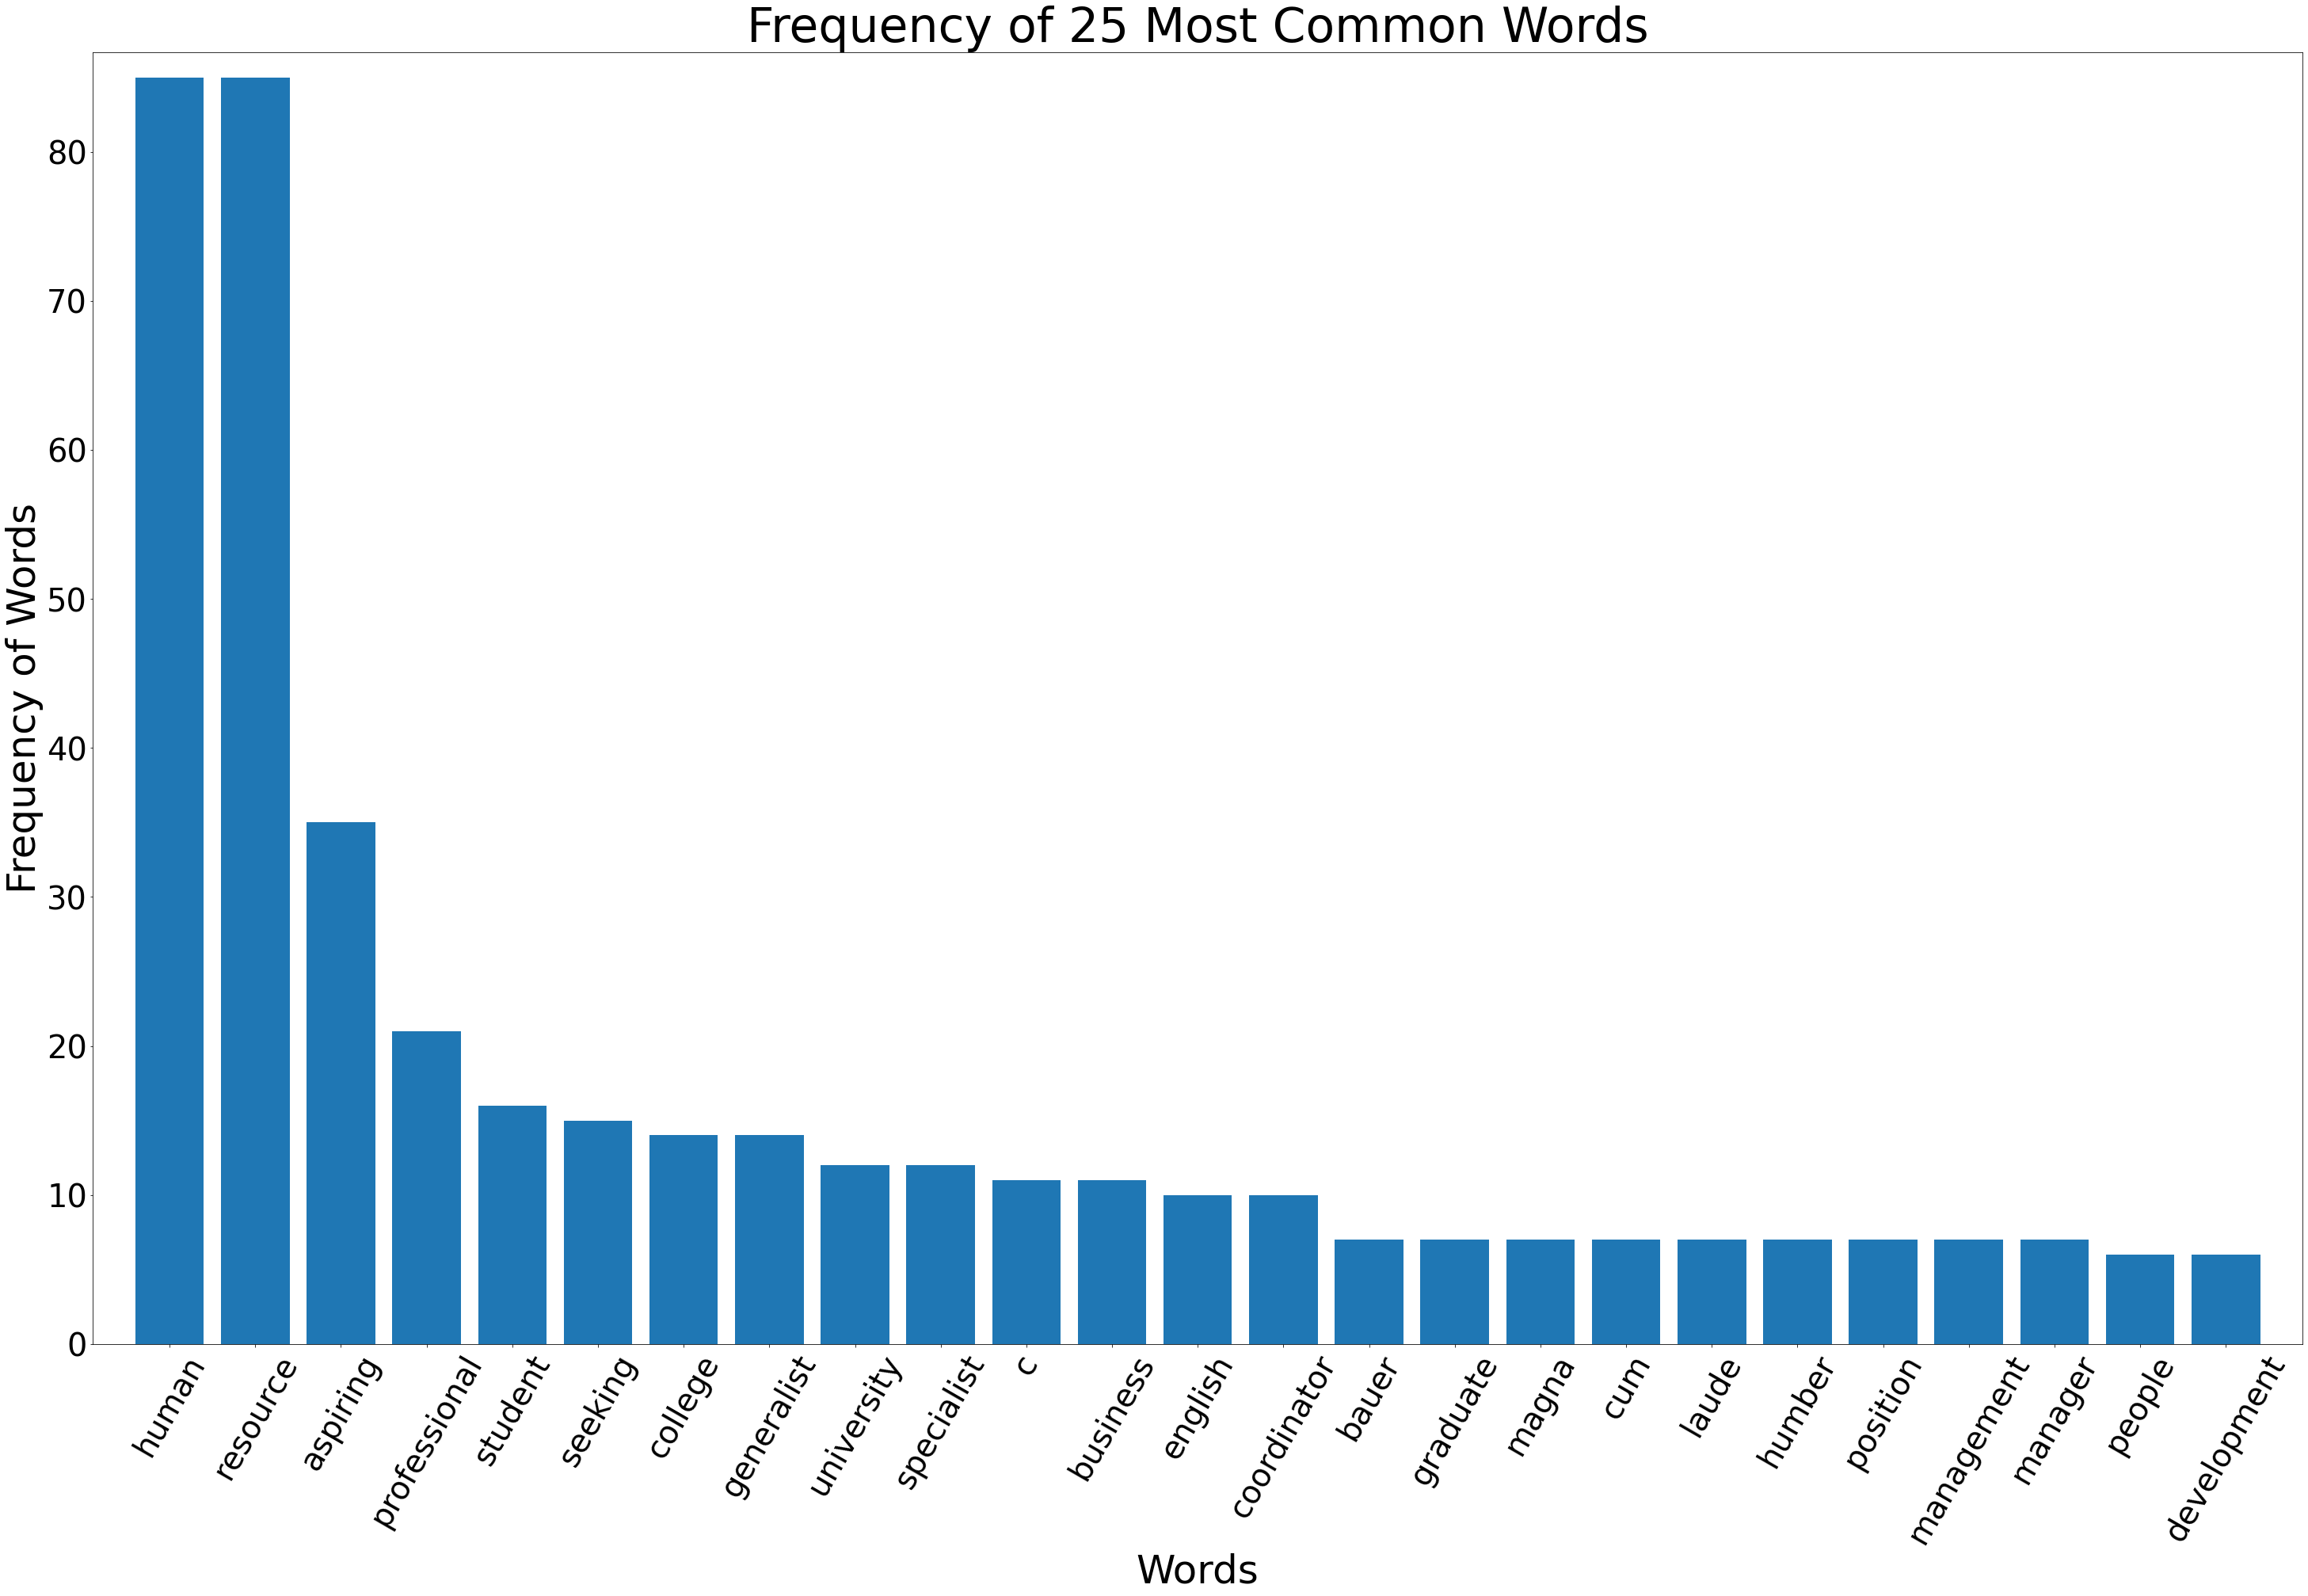

In [12]:
mostcommon_small = FreqDist(job_titles).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

### Using TFiDF Vectorizer with Cosine Similarity for ranking Words
In order to use tfidfVectorizer, we need to rejoin the words that we separated as the model only takes the joined words

In [13]:
# Join tokens
df['job_title'] = df['job_title'].apply(lambda x: ' '.join(x))

In [14]:
# Setting the vectorizer 
tvec = TfidfVectorizer(use_idf=True)

# Fitting the vectorizer on the data
df1_tvec=tvec.fit_transform(df['job_title'].values)

# Get feature names in all the documents
words_list = tvec.get_feature_names()   

print("Number of unique words: ", len(words_list))    
words_list[:10]

Number of unique words:  175


['administration',
 'administrative',
 'admission',
 'advisory',
 'always',
 'america',
 'analyst',
 'analytics',
 'army',
 'art']

## Ranking

In [15]:
# Define the search term
search_term = ["aspiring human resource", "seeking human resource"]

# Calculate TF-IDF on that search term
search_vec = tvec.transform(search_term)

# Calculate similarity score
# Each row is each job title
# Column is the search term
similarity_matrix = cosine_similarity(df1_tvec, search_vec)


# Get and rank the scores of the one search term only (similarity_matrix[i][0])
# If you calculate for many search terms, you have to change this (with for loop outside)
score_to_rank = [[similarity_matrix[i][0]] for i in range(len(similarity_matrix))]
df['tfidf_fit_score'] = score_to_rank
df.head(10)

,id,job_title,location,connection,tfidf_fit_score
0,1,c bauer college business graduate magna cum la...,"houston, texas",85,[0.28824578032951675]
1,2,native english teacher epik english program korea,kanada,501,[0.0]
2,3,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
3,4,people development coordinator ryan,"denton, texas",501,[0.0]
4,5,advisory board member celal bayar university,"i̇zmir, türkiye",501,[0.0]
5,6,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374]
6,7,student humber college aspiring human resource...,kanada,61,[0.4183468466990483]
7,8,human resource senior specialist,san francisco bay area,501,[0.2564442786580819]
8,9,student humber college aspiring human resource...,kanada,61,[0.4183468466990483]
9,10,seeking human resource human resource generali...,greater philadelphia area,501,[0.39820515964754416]


In [16]:
df.sort_values(by='tfidf_fit_score', axis=0, ascending=False, inplace=True)
df.head(20)

,id,job_title,location,connection,tfidf_fit_score
16,17,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
2,3,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
96,97,aspiring human resource professional,"kokomo, indiana area",71,[0.7427038866747069]
45,46,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
20,21,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
32,33,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
57,58,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069]
59,60,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374]
23,24,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374]
48,49,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374]


### Re-ranking using second search term

The idea here is to Re-rank our job titles when a candidate is starred



In [17]:
score_to_rank = [[similarity_matrix[i][1]] for i in range(len(similarity_matrix))]
df['tfidf_fit_score2'] = score_to_rank
df.head(10)

,id,job_title,location,connection,tfidf_fit_score,tfidf_fit_score2
16,17,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.11061150215617241]
2,3,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.0]
96,97,aspiring human resource professional,"kokomo, indiana area",71,[0.7427038866747069],[0.2850053605933205]
45,46,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.0]
20,21,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.0]
32,33,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.2598509895453585]
57,58,aspiring human resource professional,"raleigh-durham, north carolina area",44,[0.7427038866747069],[0.16053651534041624]
59,60,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374],[0.20959979275269408]
23,24,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374],[0.16053651534041624]
48,49,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374],[0.681579952620726]


In [18]:
df.sort_values(by='tfidf_fit_score2', axis=0, ascending=False, inplace=True)
df.head(20)

,id,job_title,location,connection,tfidf_fit_score,tfidf_fit_score2
15,16,native english teacher epik english program korea,kanada,501,[0.0],[0.6973597271665986]
100,101,human resource generalist loparex,"raleigh-durham, north carolina area",501,[0.21916958950027138],[0.681579952620726]
48,49,aspiring human resource specialist,greater new york city area,1,[0.6771533682378374],[0.681579952620726]
64,65,human resource coordinator intercontinental bu...,"atlanta, georgia",501,[0.16752364654186924],[0.681579952620726]
54,55,svp c human resource marketing communication c...,"houston, texas area",501,[0.2736465178183401],[0.681579952620726]
99,100,aspiring human resource manager graduating may...,"cape girardeau, missouri",103,[0.29465900818494334],[0.6520034019363098]
71,72,business management major aspiring human resou...,"monroe, louisiana area",5,[0.35852825192065135],[0.6520034019363098]
85,86,information system specialist programmer love ...,"gaithersburg, maryland",4,[0.0],[0.5960464119529412]
28,29,aspiring human resource management student see...,"houston, texas area",501,[0.3788432536217215],[0.4635127908458029]
65,66,experienced retail manager aspiring human reso...,"austin, texas area",57,[0.33319192174791257],[0.4635127908458029]
